In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.models import Sequential

In [67]:
import pandas as pd
import numpy as np

# Homework 3
Data from http://idojarasbudapest.hu/archivalt-idojaras

Daily weather information collected from 2017-01-01 to 2020-10-24

## Approach
* Train one model that can predict temperature for any given date

## Data preparation

[data.txt](./data.txt) contains the raw data I collected from the website

[data.csv](./data.csv) contains the data in tab separated format

In [130]:
# convert data.txt to tab separated format
# DO NOT NEED TO RUN
lines = []
with open("data.txt") as raw:
    line = raw.readline()
    while line:
        lines.append((line + raw.readline()).replace("\n","\t",1))
        line = raw.readline()
with open("data.csv","w") as csv:
    csv.write("Day\tTmax\tTmin\tWind[m/s]\tRain[mm]\n")
    csv.writelines(lines)

In [131]:
# Read the data from the csv
df = pd.read_csv('./data.csv',sep='\t')

Columns:
* Day: name of the day
* Tmax: max temperature of the day
* Tmin: min temperature of the day
* Wind: wind speed
* Rain: amount of rain in mm - in the dataset it stores different value in the earlier dates

In [132]:
df.head()

,Day,Tmax,Tmin,Wind[m/s],Rain[mm]
2017.01.01,vasárnap,4.0,-5.0,1.7,Napos
2017.01.02,hétfő,3.0,-2.0,2.2,Napos
2017.01.03,kedd,2.0,-3.0,5.0,Napos
2017.01.04,szerda,2.0,-2.0,5.8,Nehéz hó
2017.01.05,csütörtök,0.0,-8.0,6.7,Napos


In [133]:
df.tail()

,Day,Tmax,Tmin,Wind[m/s],Rain[mm]
2020.10.19,hétfő,14.1,8.0,2.8,0
2020.10.20,kedd,14.8,9.6,4.0,0
2020.10.21,szerda,16.6,8.9,4.2,0
2020.10.22,csütörtök,15.7,10.3,3.2,0
2020.10.23,péntek,16.4,10.8,1.8,0


Create important features for training:

* Tavg: daily average temperature - this is the target variable
* Year
* Month
* Day0: day of the month
* DoY: day of the year (from 1 to 366)
* WoY: week of the year (from 1 to 52)

In [134]:
df["Tavg"] = (df.Tmax+df.Tmin)/2
df["Day"] = df.index
df["Day_period"] = df["Day"].apply(lambda day: pd.Period(day))

df["Year"] = df["Day"].apply(lambda date: int(date.split(".")[0]))
df["Month"] = df["Day"].apply(lambda date: int(date.split(".")[1]))
df["Day0"] = df["Day"].apply(lambda date: int(date.split(".")[2]))
df["DoY"] = df["Day_period"].apply(lambda period: period.dayofyear)
df["WoY"] = df["Day_period"].apply(lambda period: period.week)

In [135]:
# example of the newly created features
df.head()

,Day,Tmax,Tmin,Wind[m/s],Rain[mm],Tavg,Day_period,Year,Month,Day0,DoY,WoY
2017.01.01,2017.01.01,4.0,-5.0,1.7,Napos,-0.5,2017-01-01,2017,1,1,1,52
2017.01.02,2017.01.02,3.0,-2.0,2.2,Napos,0.5,2017-01-02,2017,1,2,2,1
2017.01.03,2017.01.03,2.0,-3.0,5.0,Napos,-0.5,2017-01-03,2017,1,3,3,1
2017.01.04,2017.01.04,2.0,-2.0,5.8,Nehéz hó,0.0,2017-01-04,2017,1,4,4,1
2017.01.05,2017.01.05,0.0,-8.0,6.7,Napos,-4.0,2017-01-05,2017,1,5,5,1


In [136]:
#features and target for daily prediction
features = ["Year","WoY","DoY"]
target = "Tavg"

In [137]:
# normalization of the data
df["Year"]=df["Year"]/2020.0
df["WoY"]=df["WoY"]/52.0
df["DoY"]=df["DoY"]/366.0
df["Month"] = df["Month"]/12

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

In [139]:
def train_valid_test_split(df,features,target):
    """
    Split df to train, valid and test data considering the following:
    
    - X_test should contain the latest dates to test the prediction capability for the future
    - X_valid should contain random data to test the prediction for different dates in different seasons etc.
    
    - returns: train test and validation dataset with training data and labels
    """
    X_train,X_test,Y_train,Y_test = train_test_split(df[features],df[target],test_size=0.05,shuffle=False)
    X_train,X_valid,Y_train,Y_valid = train_test_split(X_train,Y_train,test_size=0.1,random_state=42)
    X_index=None
    try:
        # creates a date index for the test dataset (for plotting) - only for daily prediction
        X_index = pd.to_datetime(X_test.index)
    except:
        pass
    X_test = X_test.values
    Y_test = Y_test.values

    X_train = X_train.values
    Y_train = Y_train.values

    X_valid = X_valid.values
    Y_valid = Y_valid.values
    return X_train,X_valid,X_test,Y_train,Y_valid,Y_test,X_index

In [140]:
# create training and test data
X_train,X_valid,X_test,Y_train,Y_valid,Y_test,X_index = train_valid_test_split(df,features,target)

In [141]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [142]:
# create and early stopping instance
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

## Model

In [143]:
model = Sequential()

model.add(Dense(units=512,input_shape=[len(features)],activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.1))
model.add(Dense(units=512,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation="linear"))

In [144]:
model.compile(optimizer="adam",loss="mse",metrics=["mse"])

In [145]:
model.fit(X_train,Y_train,epochs=20,batch_size=32,validation_data=(X_valid,Y_valid),callbacks=[es])

Epoch 1/20
38/38 [==============================] - 0s 8ms/step - loss: 94.4857 - mse: 94.4666 - val_loss: 64.7941 - val_mse: 64.7762
Epoch 2/20
38/38 [==============================] - 0s 6ms/step - loss: 46.6911 - mse: 46.6737 - val_loss: 28.8083 - val_mse: 28.7915
Epoch 3/20
38/38 [==============================] - 0s 8ms/step - loss: 24.1941 - mse: 24.1774 - val_loss: 19.2302 - val_mse: 19.2137
Epoch 4/20
38/38 [==============================] - 0s 7ms/step - loss: 17.8139 - mse: 17.7975 - val_loss: 17.9777 - val_mse: 17.9615
Epoch 5/20
38/38 [==============================] - 0s 7ms/step - loss: 17.6137 - mse: 17.5975 - val_loss: 16.4872 - val_mse: 16.4711
Epoch 6/20
38/38 [==============================] - 0s 6ms/step - loss: 16.5174 - mse: 16.5013 - val_loss: 16.6656 - val_mse: 16.6496
Epoch 7/20
38/38 [==============================] - 0s 6ms/step - loss: 16.5505 - mse: 16.5346 - val_loss: 17.7262 - val_mse: 17.7103
Epoch 8/20
38/38 [==============================] - 0s 6ms/ste

## Evaluation on test dataset

In [146]:
# predictions on the test dataset
preds = model.predict(X_test)

In [147]:
from sklearn.metrics import mean_squared_error

In [148]:
print("Daily temperature error: ",mean_squared_error(Y_test,preds))

Daily temperature error:  14.720464420607767


In [149]:
import matplotlib.pyplot as plt

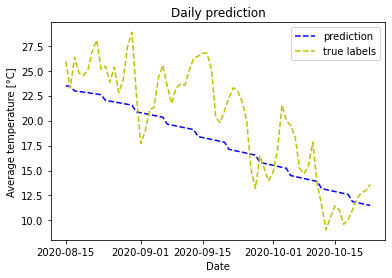

In [150]:
plt.plot(X_index,preds,'b--',label="prediction")
plt.plot(X_index,Y_test,'y--',label="true labels")
plt.legend()
plt.title("Daily prediction")
plt.xlabel("Date")
plt.ylabel("Average temperature [°C]")
plt.show()

In [153]:
def predict_day(model,day0):
    """
    day0: %Y-%m-%d format (for example: 2020-10-28)
    """
    day = pd.Period(day0)
    doy = day.dayofyear /366.0
    week = day.week /52.0
    year = day.year /2020.0
    row = (year,week,doy)
    return model.predict([row])[0]

## Predictions for:
* 2020.10.28.
* 2020.11.03.
* 2020.11.24.

In [152]:
days = ["2020-10-28","2020-11-03","2020-11-24"]
for day in days:
    print(day,predict_day(model,day),"°C")

2020-10-28 [10.415094] °C
2020-11-03 [9.250355] °C
2020-11-24 [5.6826944] °C
